# Volatility basket strategy

- Alternative setup without using backtester, raw indicator data and momentum basket construction as Pandas Dataframes only

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "01-vol-binance-data-skeleton-meme" # Used in cache paths

    cycle_duration = CycleDuration.cycle_1h

    #
    # Trading universe setup
    #

    candle_time_bucket = TimeBucket.h1

    #
    # Strategy parameters
    #
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    minimum_volatility_threshold = 0.0  # clip zero assets by volatility (if needed)
    allocation = 0.98  # How much cash to allocate to the portfolio (we need leave some in the account for rounding/costs)
    max_assets_in_portfolio = 5  # Amount of assets in the basket
    max_pairs_per_month = 5  # How many pairs we pick in the monthly inclusion criteria
    minimum_rebalance_trade_threshold = 0.1  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 10  # Don't make buys less than this amount

    # For the length of trailing sharpe used in inclusion criteria
    inclusion_criteria_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rebalance_volalitity_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    
    #
    # Live trading only
    #
    chain_id = ChainId.ethereum
    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = None  # Fill in for live trading

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 8, 15)
    backtest_trading_fee = 0.0006  # Assumed taker fee for trades
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation



# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
from pathlib import Path

import pandas as pd

from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions


#: Build a list of meme coins for memecoin basked
#: Handpicked from https://coinmarketcap.com/view/memes/
#: and https://www.binance.com/en/markets/coinInfo-Meme
MEME_TOKENS = [
    "DOGE",
    "SHIB",
    "PEPE",
    "WIF",
    "FLOKI",
    "BONK",
    # "BRETT", # Not available on Binance
    # "POPCAT",  # Not available on Binance
    # "MOG", # Not available on Binance
    # "MEW",  # Not available on Binance
    "MEME",
    "1000SATS",
    "ORDI",
    "BOME",
    "PEOPLE",
    "BANANA"
]

#: Build a list of meme coins for memecoin basked
#: Handpicked from https://www.binance.com/en/markets/coinInfo-Meme
DEFI_TOKENS = [
    "UNI",
    "AAVE",
    "MKR",
    "JUP",
    "CAKE",
    "1INCH",
    "SUSHI",
    "YFI",
    "JOE",
    "GMX",
    "OSMO",
    "ZRX",
    "MLN",
    "PERP",
    "CREAM",
    "QUICK",
    "SNX",
    "CRV"
]

#: Assets used as the buy-and-hold benchmark values for our strategy,
#: but not traded by this strategy
BENCHMARK_TOKENS = [
    "BTC",
    "ETH"
]

TRADED_TOKENS = MEME_TOKENS

#: What data to download
ALL_TOKENS = MEME_TOKENS + BENCHMARK_TOKENS

def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe."""

    tickers = {f"{m}USDT" for m in ALL_TOKENS}

    strategy_universe = create_binance_universe(
        list(tickers),
        candle_time_bucket=Parameters.candle_time_bucket,
        # stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        trading_fee_override=Parameters.backtest_trading_fee,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


/Users/moo/code/trade-executor/tradeexecutor/utils/binance.py:110: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/alternative_market_data.py:125: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/moo/code/trade-executor/tradeexecu

# Indicators

- Precalculate indicators used by the strategy

In [4]:
import pandas as pd
import numpy as np
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver


def trailing_sharpe(
    close: pd.Series, 
    window_length_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    vol = returns.rolling(window=window_length_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


def trailing_sharpe_business_month(close, window_length_bars, pair, dependency_resolver) -> pd.Series:
    """Snap the trailing returns to business month start day/hour."""

    hour = 8  # 8AM

    def first_day_8am(group):
        target_time = group.index[0].floor('D') + pd.Timedelta(hours=hour)
        return group.loc[target_time] if target_time in group.index else np.NaN
        #return group.loc.get(target_time)

    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    

    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    ewm = trailing_sharpe.ewm(span=ann_factor/4).mean()  # Quaterly
    first_day_series = ewm.resample('MS').apply(first_day_8am)
    # first_day_series.attrs["time_bucket"] = TimeBucket.d30  # Hint this is monthly data
    return first_day_series


def available_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Get the available tradeable pairs on each date.

    - Pairs for which have business month trailing sharpe available
    
    - Because the trading universe is only expanding, this number is only going up
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month")
    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')
    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicator_set = IndicatorSet()
    indicator_set.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.inclusion_criteria_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "trailing_sharpe_business_month",
        trailing_sharpe_business_month,
        {"window_length_bars": parameters.inclusion_criteria_bars},
        IndicatorSource.close_price,
        order=2,  # After trailing_sharpe
    )    
    indicator_set.add(
        "available_pairs",
        available_pairs,  
        {},  
        IndicatorSource.strategy_universe,
        order=3,  # After trailing_sharpe_business_month
    )       
    return indicator_set


indicators = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=create_indicators,
    parameters=parameters,
)

Reading cached indicators trailing_sharpe, volatility, trailing_sharpe_business_month, available_pairs for 14 …

Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_1h_14_2022-08-15-2024-08-15_nff


# Available assets

- Check how the asset universe developers and what is a meaningful time range for us

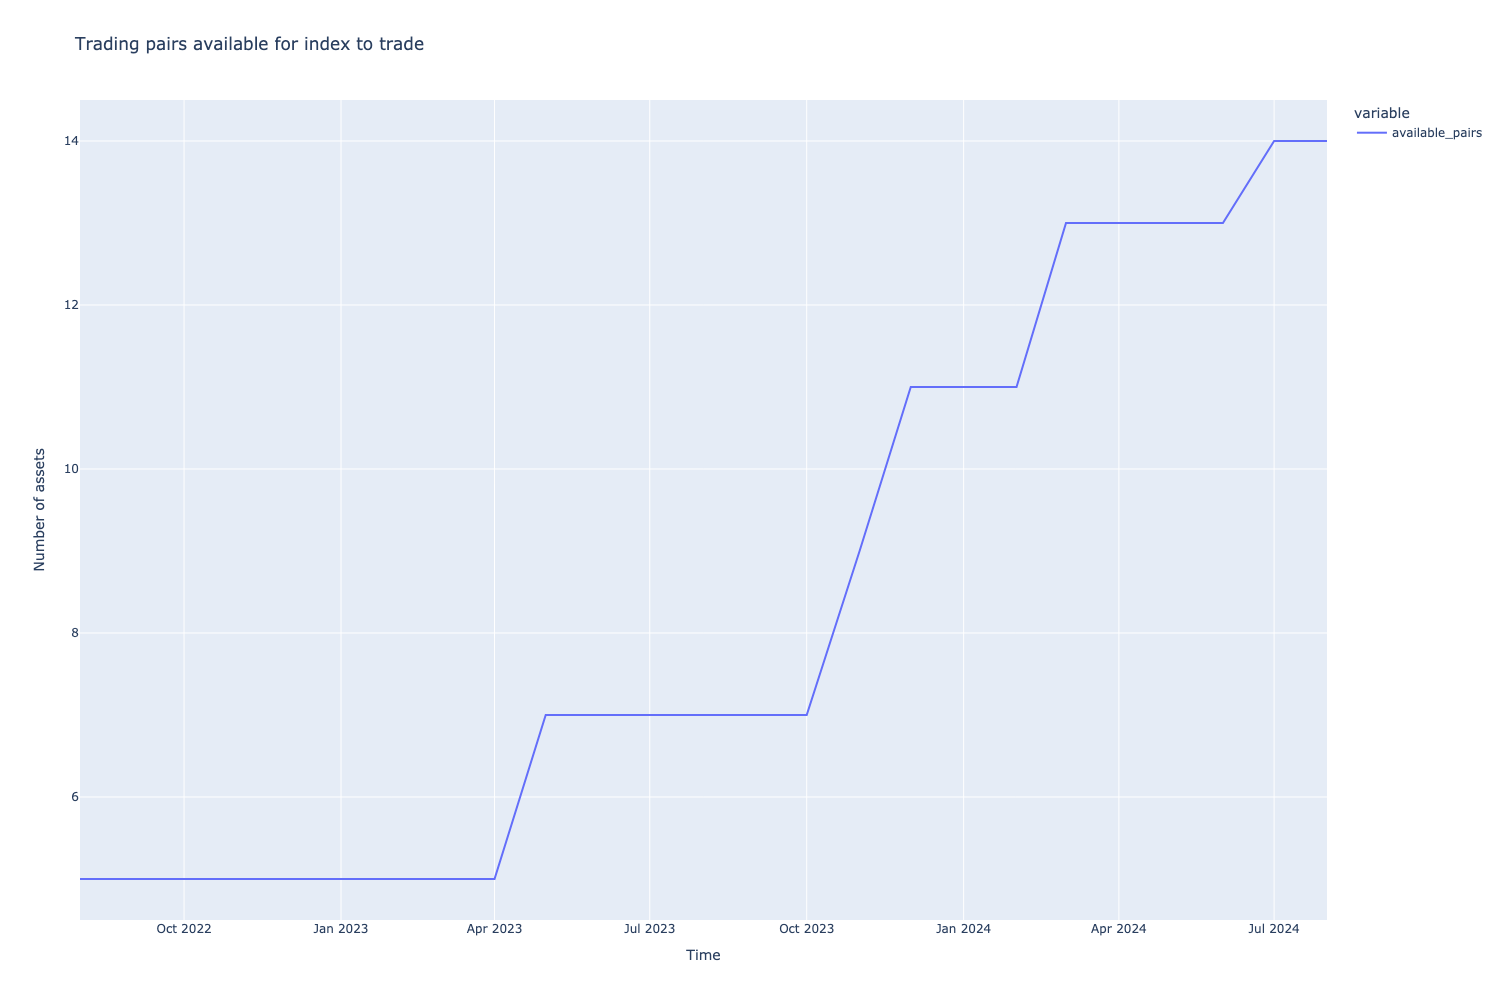

In [5]:
import plotly.express as px

df = pd.DataFrame({
    "available_pairs": indicators.get_indicator_series("available_pairs")
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

# Indicator data

- Display sharpe et. al for each asset
- Manually inspect that the indicator data looks correct

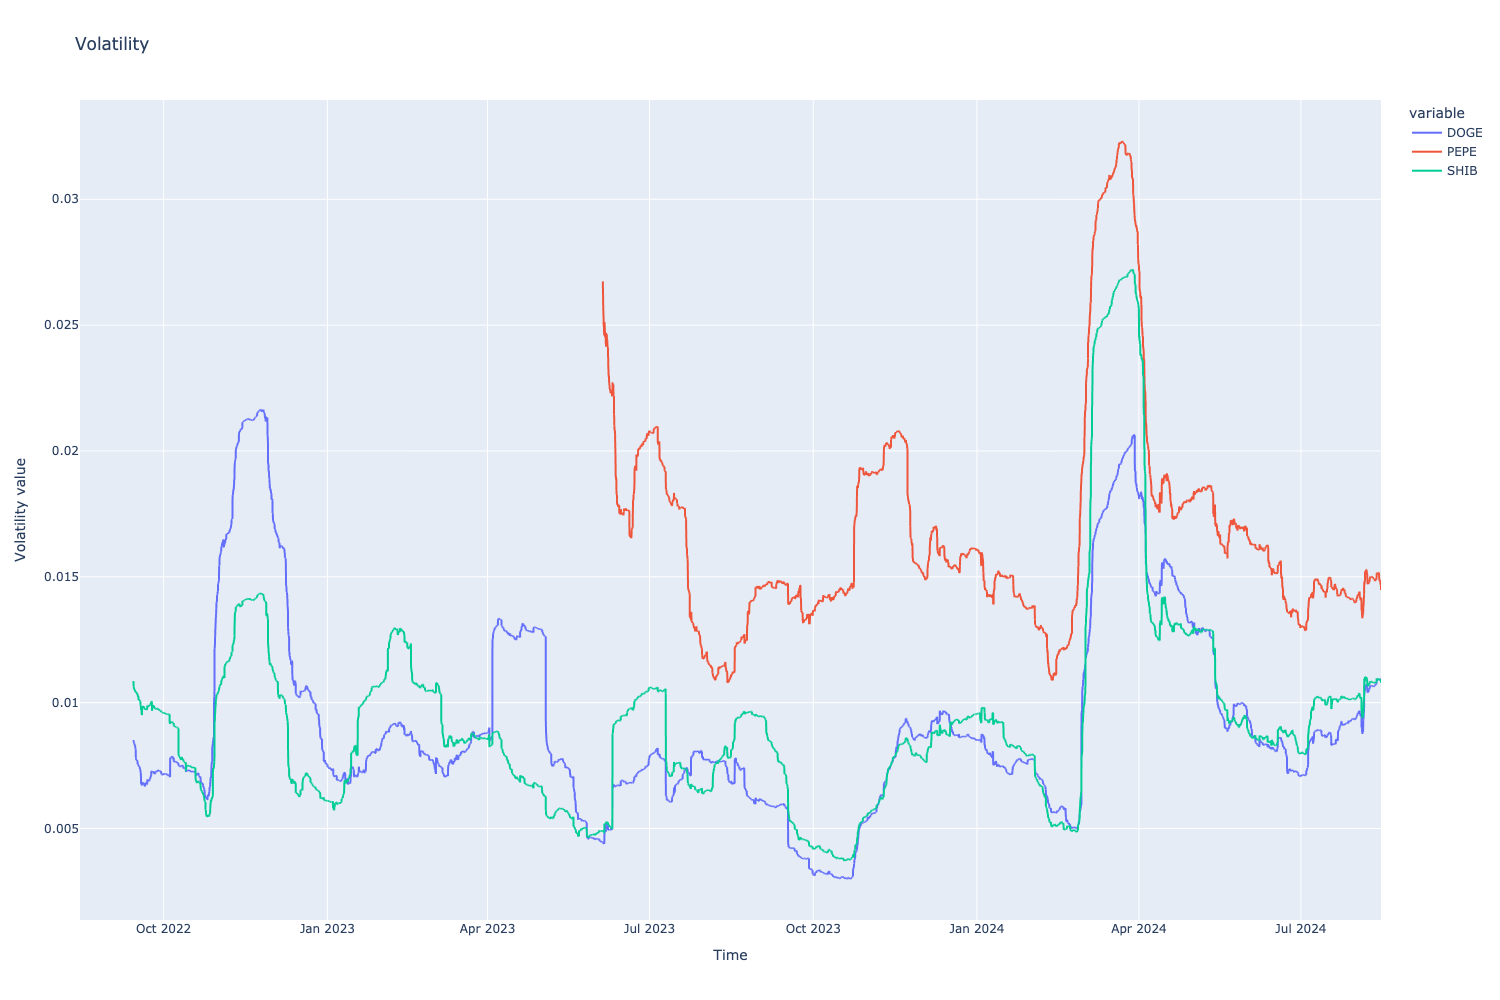

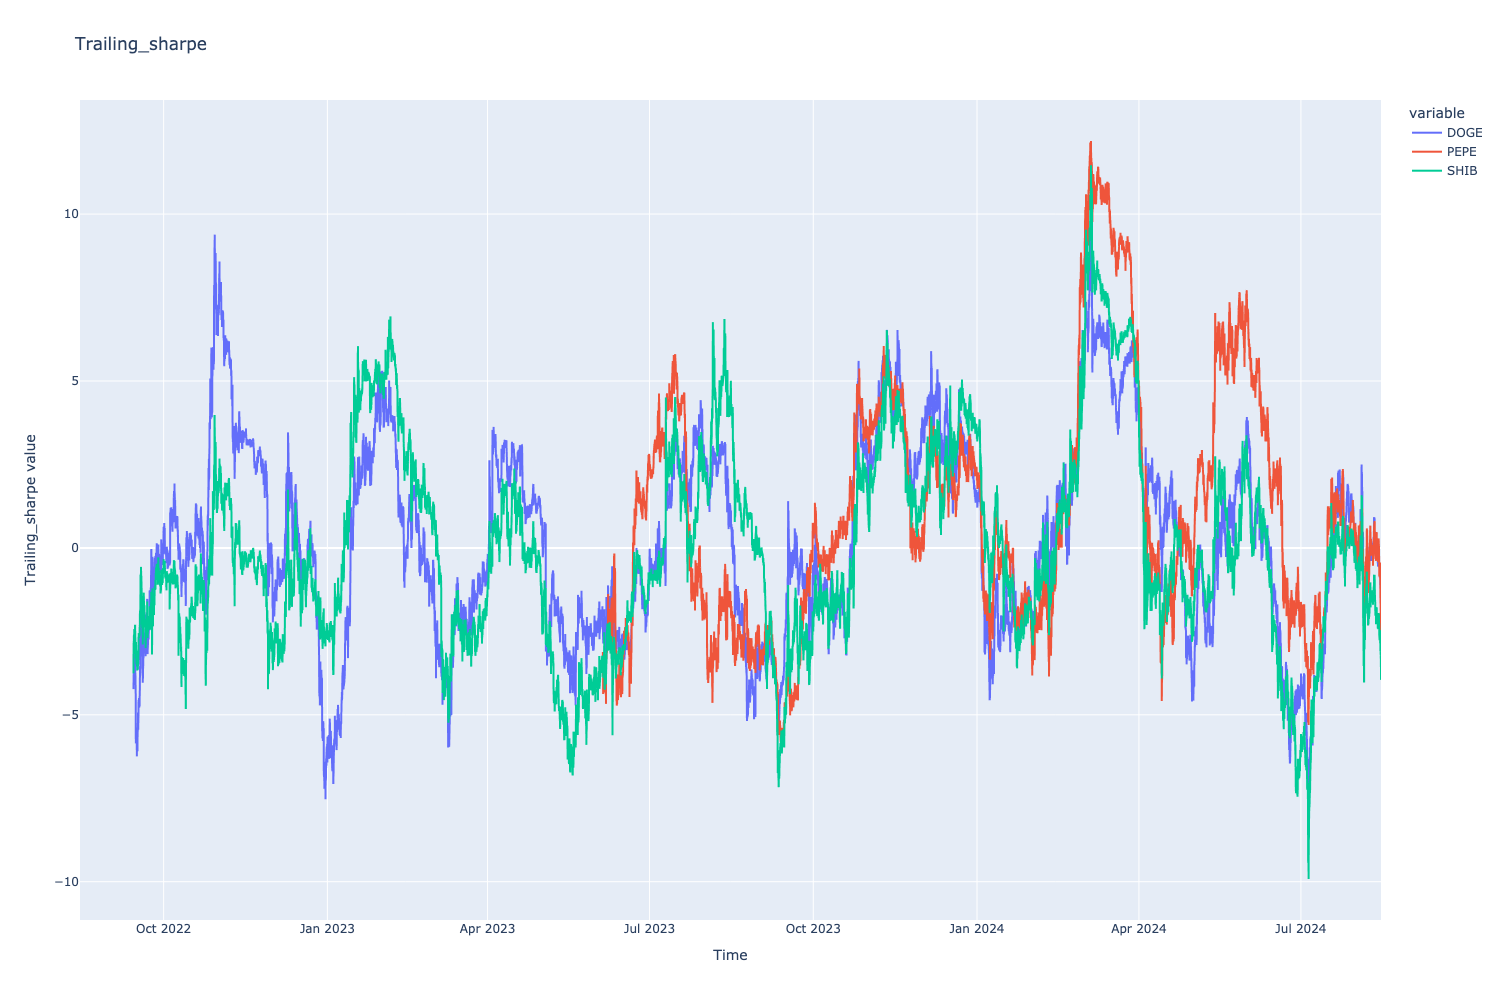

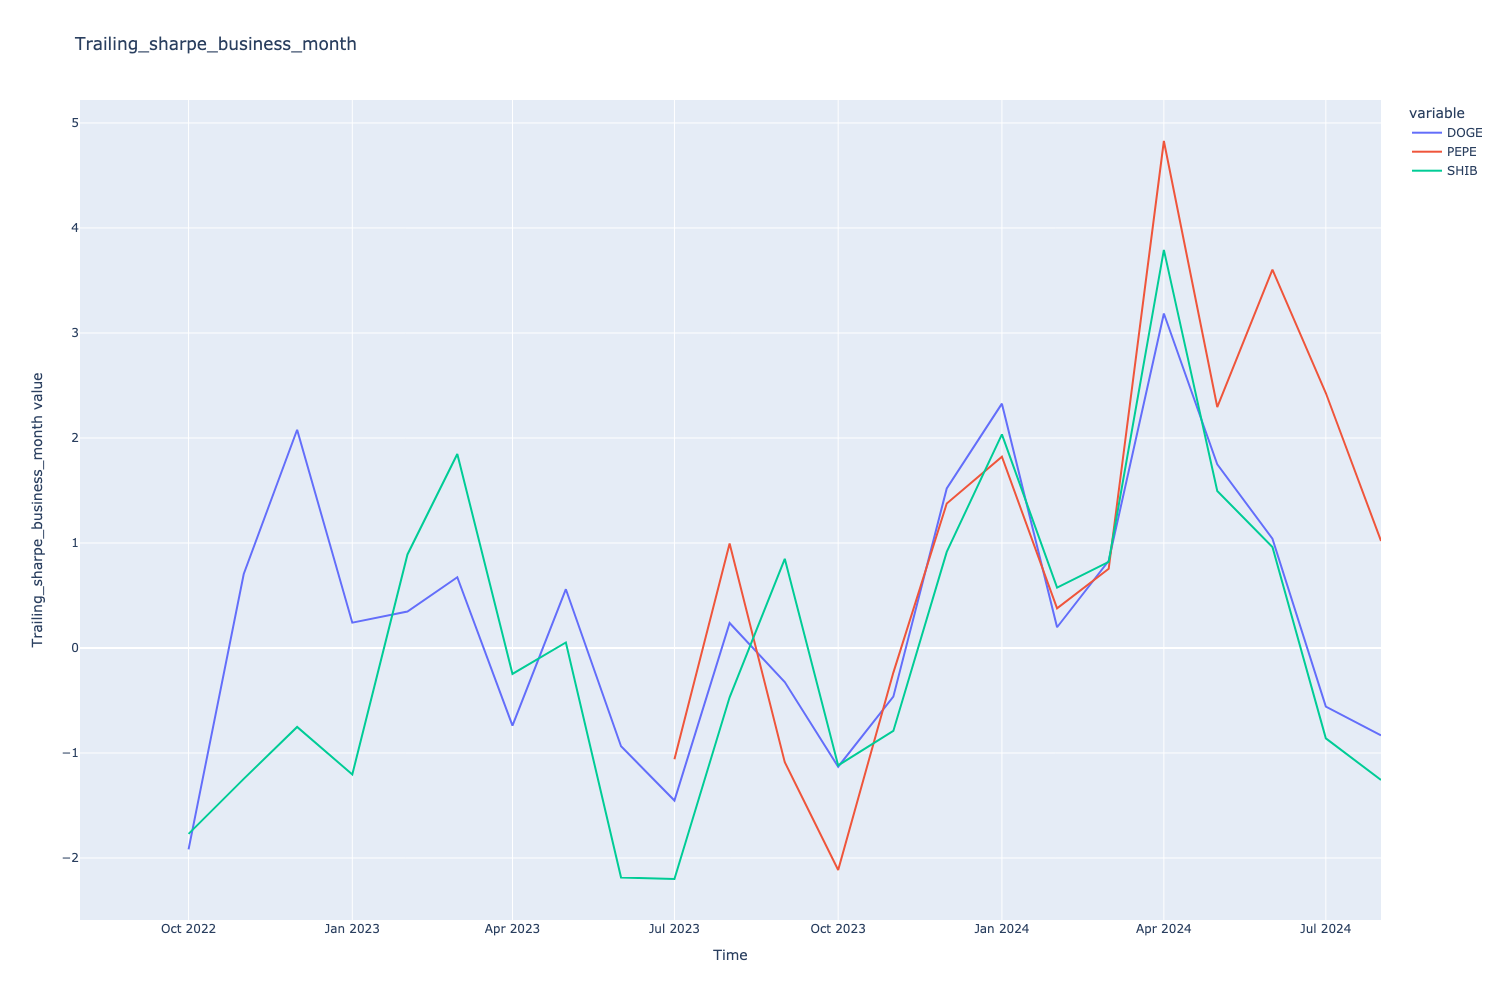

In [10]:
import plotly.express as px

selected_assets = ["DOGE", "PEPE", "SHIB"]

for indicator_name in ["volatility", "trailing_sharpe", "trailing_sharpe_business_month"]:

    data = {}
    for symbol in selected_assets:

        pair = strategy_universe.get_pair_by_human_description([
            ChainId.centralised_exchange, 
            "binance", 
            symbol,
            "USDT"
        ])

        data[symbol] = series = indicators.get_indicator_series(indicator_name, pair=pair)

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [6]:
series = indicators.get_indicator_series("available_pairs")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-05-01 00:00:00 - 2024-08-01 00:00:00


# Weights 

- Calculate asset weighting in the portfolio

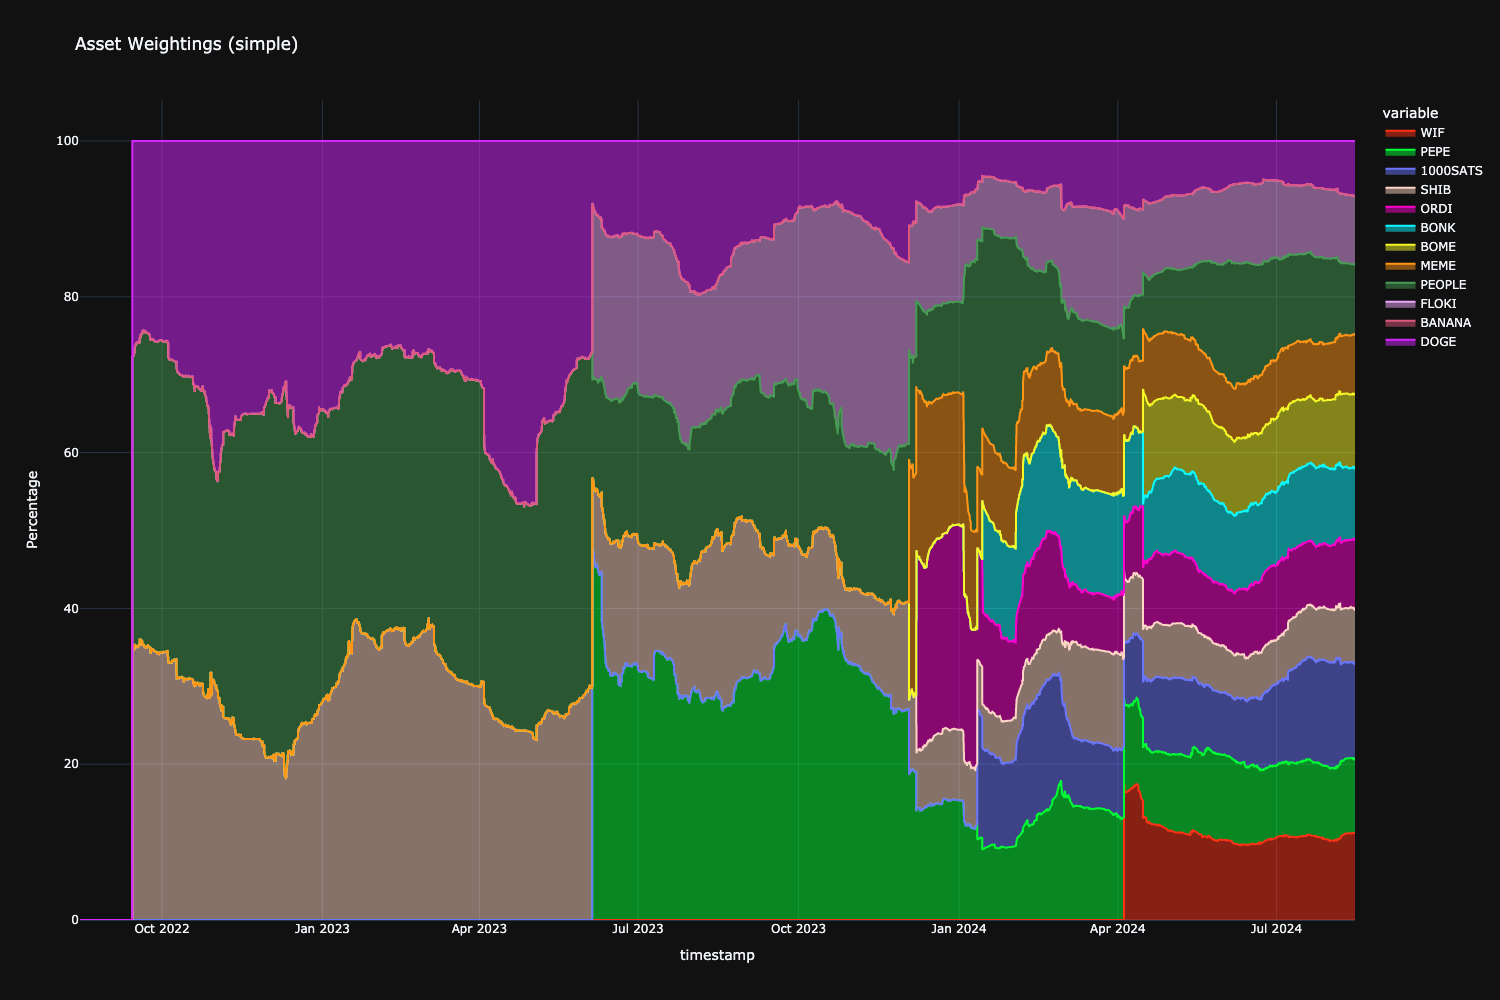

In [11]:
import plotly.express as px
import plotly.colors as colors

color_palette = colors.qualitative.Light24

data = {}
for pair in strategy_universe.iterate_pairs():

    symbol = pair.base.token_symbol
    
    if symbol not in TRADED_TOKENS:
        # Benchmark asset, skip
        continue

    data[symbol] = series = indicators.get_indicator_series("volatility", pair=pair)

df = pd.DataFrame(data)
df_normalized = df.div(df.sum(axis=1), axis=0) * 100

fig = px.area(
    df_normalized, 
    title='Asset Weightings (simple)',
    labels={'index': 'Time', 'value': 'Percentage'},
    template='plotly_dark',
    color_discrete_sequence=color_palette,
)

fig.show()

# Benchmark data

- Equity curve shows how your strategy accrues value over time

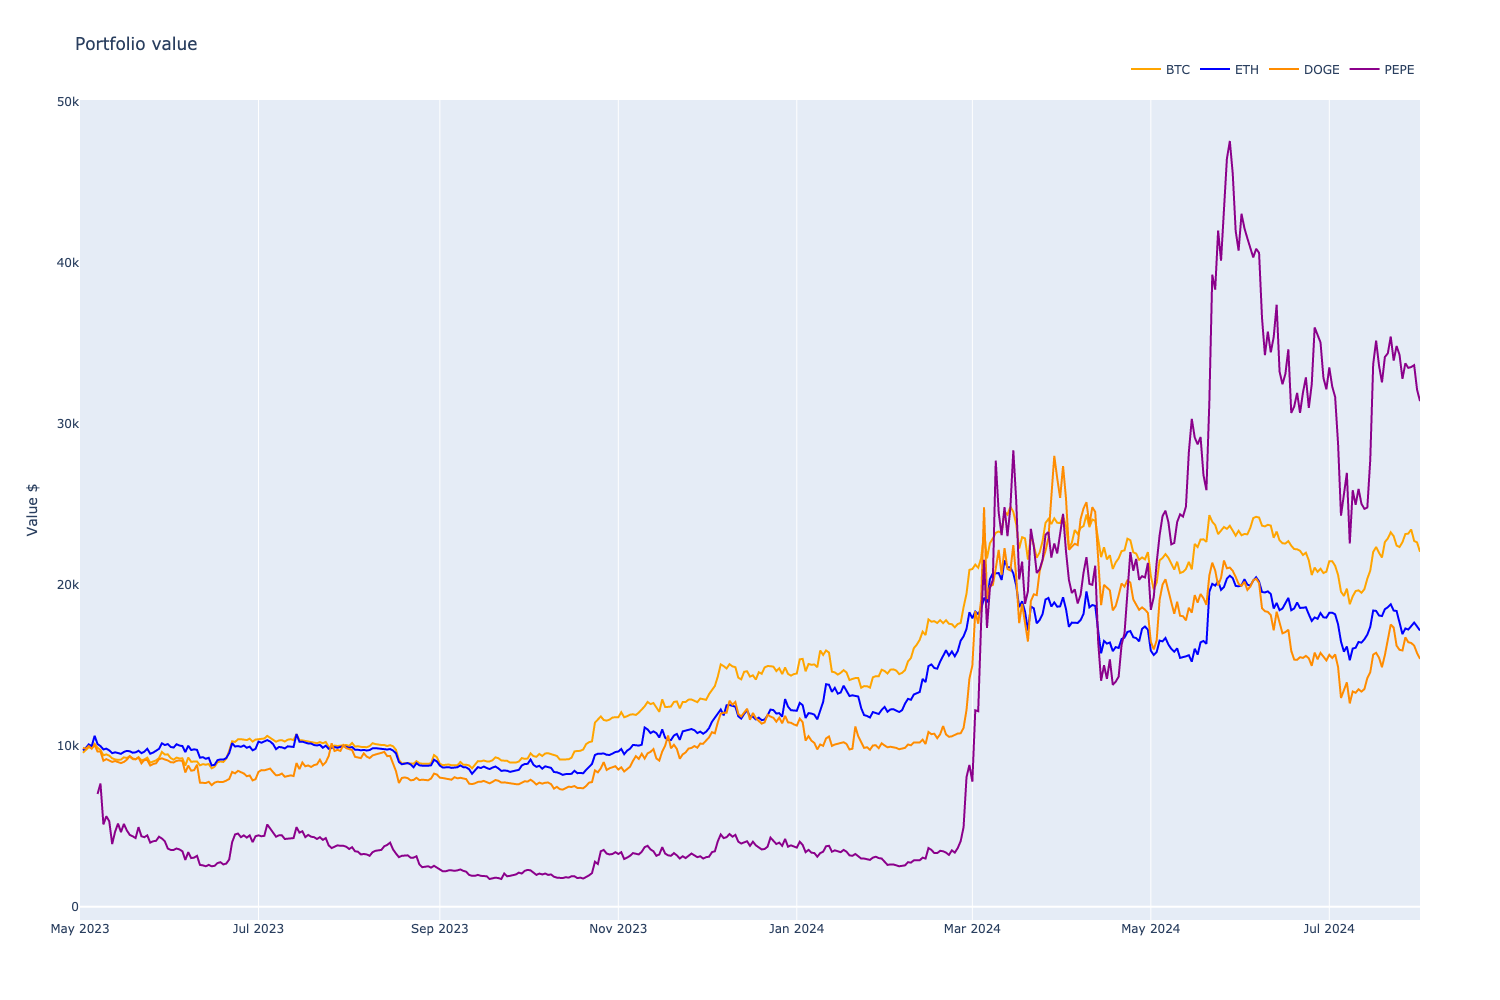

In [7]:
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

initial_cash = 10_000

# Some asset we check in our index
example_assets = ["BTC", "ETH", "DOGE", "PEPE"]  

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=initial_cash,
    max_count=4,
    start_at=backtest_start,
    interesting_assets=example_assets,
)

fig = visualise_equity_curve_benchmark(
    state=None,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=False,
    start_at=backtest_start,
    end_at=backtest_end,
)

fig.show()